In [1]:
import numpy as np
import open3d as o3d
import copy
import csv
from matplotlib import pyplot as plt
from open3d import visualization

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [55]:
#FOR TUM DATASET
x = [] #dvs pixel x in mm
y = [] #dvs pixel y in mm
depth = [] #depth from depth sensor
time_stamp = [] 
x_pixel = [] #dvs pixel x in mm
y_pixel = [] #dvs pixel y 


#events.tsv: A TSV file where each row corresponds to one event.
# Provided data is: PrimeSense image coordinates (x,y), PrimeSense depth measurement,
# EDVS image coordinates (x,y), Timestamp (in microsenconds), EDVS parity flag

with open('/home/bru/Dev/DATA/data/scn2c_take01/take01/events.csv', encoding="Latin-1") as csvfile:  #change this according to your file 
    reader = list(csv.reader(csvfile, delimiter=","))

num_events = len(reader)
num_events_batch = 5000
import pandas as pd

for i in range(0,num_events):
    depth.append((reader[i][2]))
    x.append(((int(reader[i][3])/128)-0.5)*1000) # convert x_pixels to x in millimeters (according to camera intrinsics of DAVIS128) K = [128, 0, 64; 0, 128, 64; 0, 0, 1]
    y.append(((int(reader[i][4])/128)-0.5)*1000) # convert y_pixels to y in millimeters
    x_pixel.append(int(reader[i][3])) 
    y_pixel.append(int(reader[i][4]))
    time_stamp.append((reader[i][5]))
depth = np.array(depth).astype(np.float64)
Max_depth = depth.max()
Min_depth = depth.min()
x = np.array(x)
x = x-x.min()
y = np.array(y)
y = y-y.min()


In [57]:
iEv = 0 #num event
iBatch = 0 #num batch
data_size = (num_events_batch ,3) 
num_arr = 0
while True:
    # Check if we have processed all events
    if (iEv + num_events_batch > num_events):
        break
        
    # Select subset of events or data
    iEv += num_events_batch
    iBatch += 1
    
    depth_batch = np.array(depth[iEv+0:iEv+num_events_batch]).astype(np.float64)
    x_batch = np.array(x[iEv+0:iEv+num_events_batch]).astype(np.float64)
    y_batch = np.array(y[iEv+0:iEv+num_events_batch]).astype(np.float64)
    #batches = (np.c_[x_batch,y_batch, depth_batch]).astype(np.float64)
    #print(batches)
    x_max = int(x_batch.max())
    y_max = int(y_batch.max())
    if y_max < x_max:
        img = np.zeros((int(x_batch.max()+1),int(x_batch.max()+1)))
        count = np.zeros((int(x_batch.max()+1),int(x_batch.max()+1))) 
    else:
        img = np.zeros((int(y_batch.max()+1),int(y_batch.max()+1)))
        count = np.zeros((int(y_batch.max()+1),int(y_batch.max()+1)))
        
        for i in range(num_events_batch):
        # Need to convert the polarity bit from {0,1} to {-1,+1} and accumulate
            img[int(y_batch[i]),int(x_batch[i])] += (int(depth_batch[i]))
            count[int(y_batch[i]),int(x_batch[i])] += 1

    # Compute per-pixel average if count at the pixel is >1
        count[count < 1] = 1  # to avoid division by zero
        img = img / count*2
    
        print(img.shape)             
        plt.imshow(img,cmap='jet_r',clim=(Min_depth,Max_depth))
        plt.show()
   

In [10]:
x_pos = []
y_pos = []
z_pos = []
x_rot = []
y_rot = []
z_rot = []
T_rest = np.identity(4)
T_new = []
T_orj = []

num_batch_apart = 1 #skip this much point cloud (When point clouds are too close to each other, there is not much change)
#Can be dynamically change!!

for i in range(iBatch-num_batch_apart):
    source = o3d.io.read_point_cloud("/home/bru/Dev/DATA/data/scn2c_take01/take01/point_clouds/depth_event_%08d.ply" %i)
    target = o3d.io.read_point_cloud("/home/bru/Dev/DATA/data/scn2c_take01/take01/point_clouds/depth_event_%08d.ply" %(i+num_batch_apart))
    
    max_correspondence_distance = 30   # mm, for ICP
    trans_init = np.identity(4) #for ICP to initialize transformation matrix might be changed to see how robust the algorithm is??
    
    evaluation = o3d.pipelines.registration.evaluate_registration(source, target,
                                                    max_correspondence_distance, trans_init)
          
    #POINT TO POINT ICP
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=3000))
    
    # The class TransformationEstimationPointToPoint provides functions to compute the residuals and Jacobian matrices of the point-to-point ICP objective. 
    # The function registration_icp takes it as a parameter and runs point-to-point ICP to obtain the results.
  
    T = reg_p2p.transformation
    T_orj.append(T) # list of delta T, transformations from one scene to another
   
    T_rest = np.dot(T_rest, T)
print(T_rest)
    #T_new.append(T_rest)
    

[[ 9.78757280e-01 -2.01487564e-01  3.79070908e-02  1.92088400e+01]
 [ 1.93542272e-01  9.69023673e-01  1.53409615e-01 -4.44943593e+02]
 [-6.76429979e-02 -1.42814153e-01  9.87435336e-01 -4.72967256e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [38]:
source = o3d.io.read_point_cloud("/home/bru/Dev/DATA/data/scn2c_take01/take01/point_clouds/depth_event_%08d.ply" %0)
target = o3d.io.read_point_cloud("/home/bru/Dev/DATA/data/scn2c_take01/take01/point_clouds/depth_event_%08d.ply" %195)

print(o3d.geometry.PointCloud.get_max_bound(source))
print(o3d.geometry.PointCloud.get_max_bound(target))
bounding_box = o3d.geometry.AxisAlignedBoundingBox(np.array([0,0,0]), np.array([493,440,2000]))
#source = o3d.geometry.PointCloud.crop(source,bounding_box)
#target = o3d.geometry.PointCloud.crop(target,bounding_box)
print(o3d.geometry.PointCloud.get_min_bound(source))
print(o3d.geometry.PointCloud.get_min_bound(target))

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    
    source_temp.transform(transformation)
    
    #o3d.visualization.draw([source_temp, target_temp])
    o3d.visualization.draw_geometries(
        [source_temp,
         target_temp])
    
draw_registration_result(source, target, T_rest)

#max_correspondence_distance = 30   # mm, for ICP
#evaluation = o3d.pipelines.registration.evaluate_registration(source, target,
                                                    #max_correspondence_distance, T_rest)

#print(evaluation)

[ 492.188  437.5   4463.   ]
[ 492.188  429.688 3576.   ]
[-500.    -453.125 1328.   ]
[-500.    -476.562 1050.   ]


In [63]:
def backproject(points_3d, intrinsic_matrix, extrinsic_matrix):
    """
    Backproject 3D points to 2D image points.
   

    :param points_3d: Nx3 numpy array of 3D points.
    :param intrinsic_matrix: 3x3 intrinsic camera matrix K.
    :param extrinsic_matrix: 4x4 extrinsic camera matrix [R|t].
    :return: Nx2 numpy array of 2D points.
    """
    # Convert points to homogeneous coordinates
    points_from_pcd = np.asarray(points_3d.points)
    points_3d_hom = np.hstack((points_from_pcd, np.ones((points_from_pcd.shape[0], 1))))

    # Apply extrinsic matrix
    points_cam_hom = np.dot(points_3d_hom, extrinsic_matrix.T)

    # Convert from homogeneous to 3D coordinates
    points_cam = points_cam_hom[:, :3] / points_cam_hom[:, 3, np.newaxis]

    # Apply intrinsic matrix
    points_img_hom = np.dot(points_cam, intrinsic_matrix.T)

    # Convert from homogeneous to 2D coordinates
    points_img = points_img_hom[:, :2] / points_img_hom[:, 2, np.newaxis]

    return points_img

K = np.array([
    [128, 0, 64],  # fx, 0, cx
    [0, 128, 64],  # 0, fy, cy
    [0, 0, 1]      # 0, 0, 1
])

T_init = np.identity(4)

In [66]:
source = o3d.io.read_point_cloud("/home/bru/Dev/DATA/data/scn2c_take01/take01/point_clouds/depth_event_%08d.ply" %0)
target = o3d.io.read_point_cloud("/home/bru/Dev/DATA/data/scn2c_take01/take01/point_clouds/depth_event_%08d.ply" %195)

source_points = backproject(source, K, T_rest)
target_points = backproject(target, K, T_init)

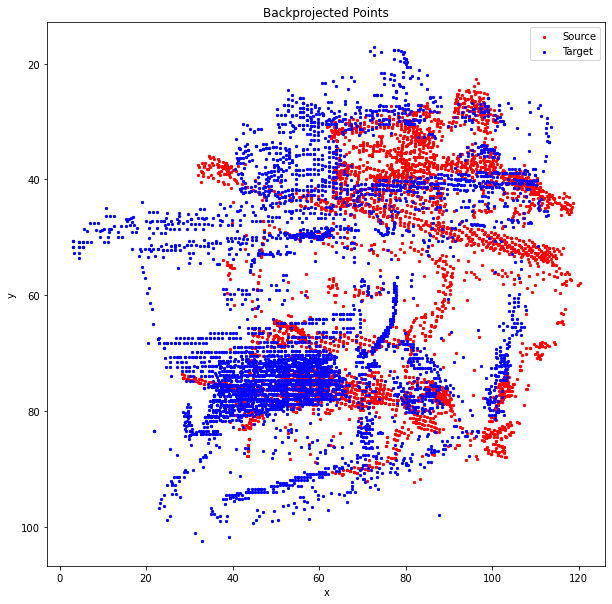

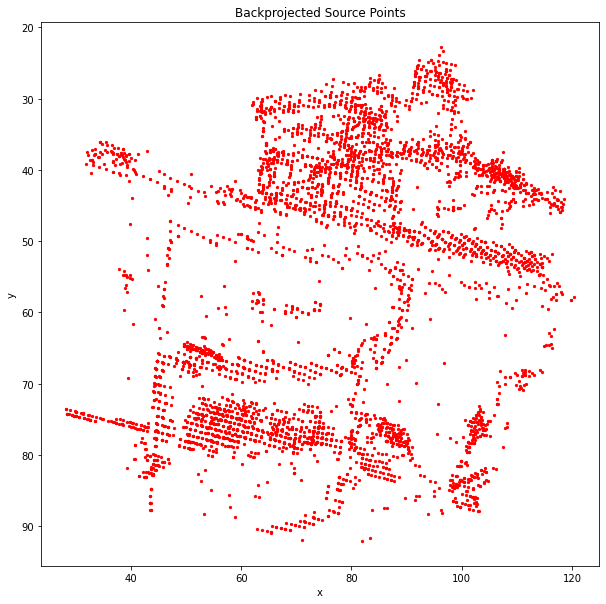

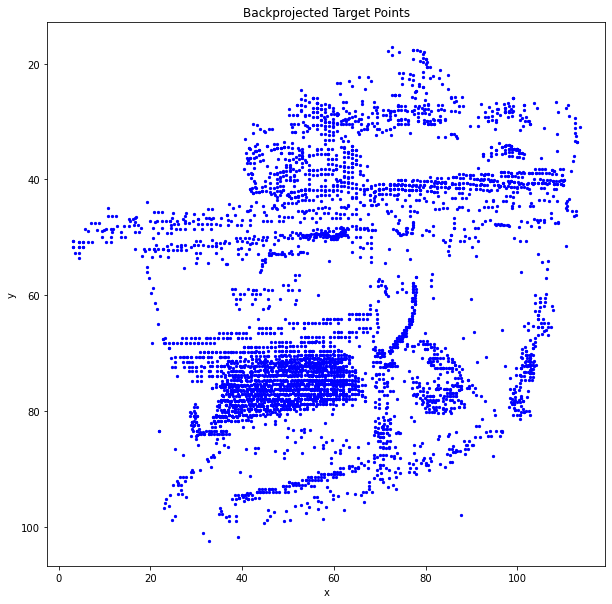

In [70]:
# Extract x and y coordinates
source_x = source_points[:, 0]
source_y = source_points[:, 1]
target_x = target_points[:, 0]
target_y = target_points[:, 1]

# Plot the points
plt.figure(figsize=(10, 10))
plt.scatter(source_x, source_y, s=5, c='red', label='Source')
plt.scatter(target_x, target_y, s=5, c='blue', label='Target')
plt.title('Backprojected Points')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()  # Flip the y-axis to match image coordinates
plt.legend()
plt.show()

# Plot source points
plt.figure(figsize=(10, 10))
plt.scatter(source_x, source_y, s=5, c='red')
plt.title('Backprojected Source Points')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()  # Flip the y-axis to match image coordinates
plt.show()

# Plot target points
plt.figure(figsize=(10, 10))
plt.scatter(target_x, target_y, s=5, c='blue')
plt.title('Backprojected Target Points')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()  # Flip the y-axis to match image coordinates
plt.show()